In [1]:
import cv2
import numpy as np
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imutils
import os
from sklearn.utils import shuffle


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
path="./mri_data/"


In [ ]:
os.makedirs('./augmented-images')
os.makedirs('./augmented-images/yes')
os.makedirs('./augmented-images/no')

In [5]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [12]:
augmented_data_path ='./augmented-images/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=path+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=path+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

In [6]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

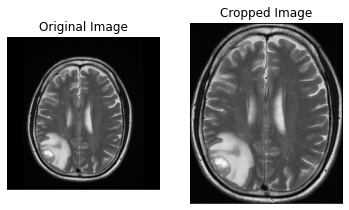

In [8]:
ex_img = cv2.imread(path+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [9]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [13]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 4124
X shape is: (4124, 240, 240, 3)
y shape is: (4124, 1)


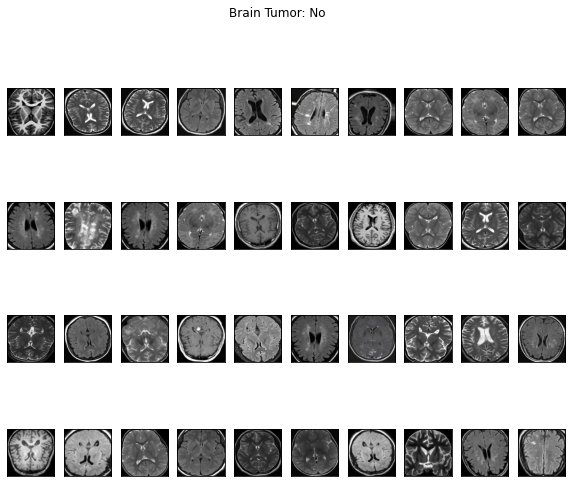

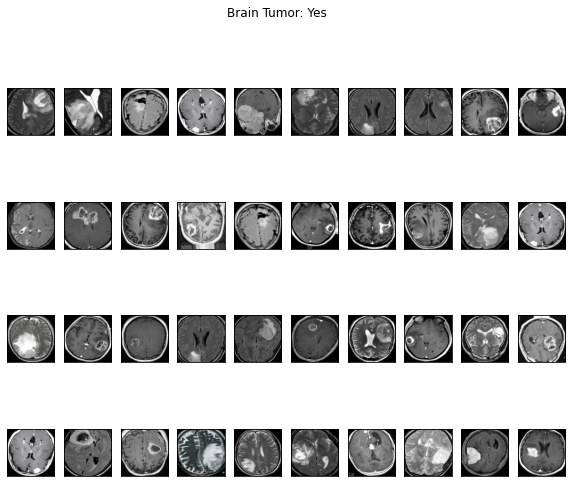

In [15]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()
        
plot_sample_images(X, y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)

In [44]:
def build_model(input_shape):
    X_input = tf.keras.Input(input_shape) 
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input) 
    
    X = tf.keras.layers.Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X) 
    X = tf.keras.layers.MaxPooling2D((4, 4))(X) 
    X = tf.keras.layers.MaxPooling2D((4, 4))(X) 
    X = tf.keras.layers.Dropout(.3)(X) 
    X = tf.keras.layers.Flatten()(X) 
    X = tf.keras.layers.Dense(1, activation='sigmoid')(X) 
    model = tf.keras.Model(inputs = X_input, outputs = X)
    
    return model

In [45]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation_5 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0   

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
87/87 [==============================] - 109s 1s/step - loss: 0.7157 - accuracy: 0.6908 - val_loss: 0.6262 - val_accuracy: 0.6297
Epoch 2/20
87/87 [==============================] - 107s 1s/step - loss: 0.5214 - accuracy: 0.7754 - val_loss: 0.5738 - val_accuracy: 0.6833
Epoch 3/20
87/87 [==============================] - 464s 5s/step - loss: 0.4288 - accuracy: 0.8205 - val_loss: 0.8745 - val_accuracy: 0.5996
Epoch 4/20
87/87 [==============================] - 101s 1s/step - loss: 0.4369 - accuracy: 0.8112 - val_loss: 0.3642 - val_accuracy: 0.8428
Epoch 5/20
87/87 [==============================] - 101s 1s/step - loss: 0.3349 - accuracy: 0.8496 - val_loss: 0.6952 - val_accuracy: 0.6988
Epoch 6/20
87/87 [==============================] - 101s 1s/step - loss: 0.3746 - accuracy: 0.8323 - val_loss: 0.5466 - val_accuracy: 0.7752
Epoch 7/20
87/87 [==============================] - 103s 1s/step - loss: 0.3250 - accuracy: 0.8629 - val_loss: 0.3356 - val_accuracy: 0.8597
Epoch 8/20
87